In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DAG").getOrCreate()
print("Let's learn DAGs")

Let's learn DAGs


In [2]:
transactions_file = "transactions.parquet"
df_transactions = spark.read.parquet(transactions_file)
#df_transactions.printSchema()

- Following job was created while reading the file.
- But why a job for just reading the file?
- This is because Spark just reades the meta data of the file in order for it's optimisation
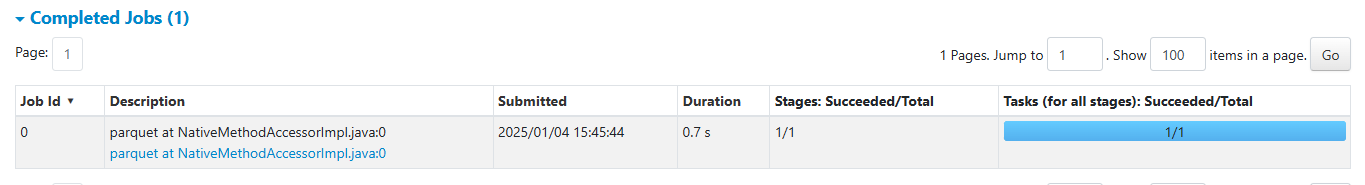

In [3]:
df_transactions.show(5, False)

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|cust_id   |start_date|end_date  |txn_id         |date      |year|month|day|expense_type |amt   |city       |
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|10   |7  |Entertainment|10.42 |boston     |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|3    |27 |Motor/Travel |44.34 |portland   |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TETSXIK4BLXHJ6W|2011-04-11|2011|4    |11 |Entertainment|3.18  |chicago    |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TQKL1QFJY3EM8LO|2018-02-22|2018|2    |22 |Groceries    |268.97|los_angeles|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYL6DFP09PPXMVB|2010-10-16|2010|10   |16 |Entertainment|2.66  |chicago    |
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
only showi

- A **showString** Job is created when I called the .show() method. It has an input unlike the initial stage

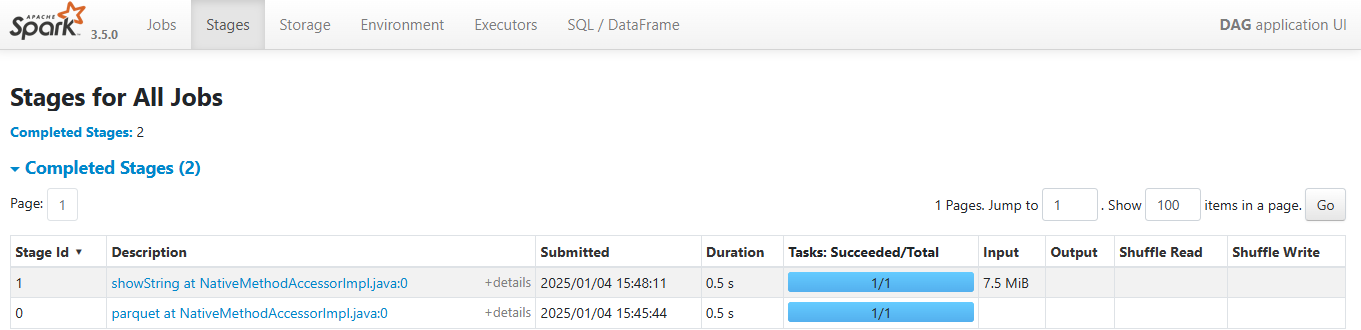

#### DAG for the Show Job
Since it's a Parquet file it converts it from columnar to Row based format
  
##### ColumnarToRow

number of output row  -> The 4,096 output rows in the ColumnarToRow step represent all the rows read from the Parquet files



number of input batches -> 1 batch indicates that all the rows (4,096) were processed together in memory. This typically happens when the data size is small enough to fit in a single batch.: 1
  
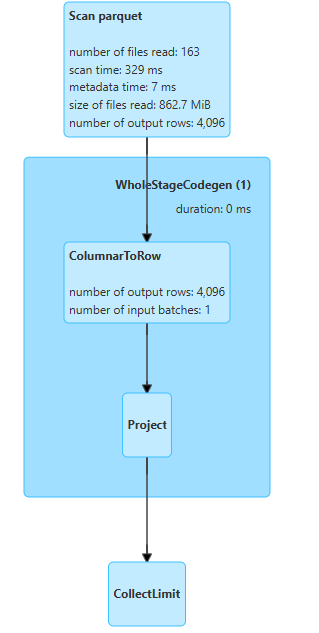

In [4]:
customers_file = "customers.parquet"
df_customers = spark.read.parquet(customers_file)
#df_customers.printSchema()

## 1. DAG for Narrow Transforms


In [5]:
from pyspark.sql import functions as F

In [9]:
df_narrow_transform = df_customers.filter(F.col('city')=='boston')\
                                        .withColumn('first_name', F.split('name', ' ').getItem(0))\
                                        .withColumn('last_name', F.split('name', ' ').getItem(1))\
                                        .withColumn('age', F.col('age')+F.lit(5))\
                                        .select("cust_id", "first_name", "last_name", "age", "gender", "birthday")

# Lets write the dataframe to invoke a Spark job - this will read the whole dataset unlike .show()
# noop - No operation, simulates a write but does not actually write. Good for testing

df_narrow_transform.write.format("noop").mode("overwrite").save('df_narrow_transform.parquet')

- All the withColumn and select commands are put into the Project stage before that a filter is applied 

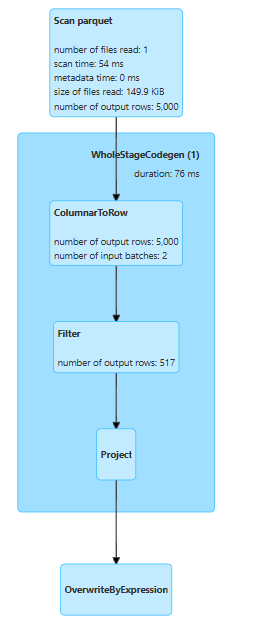

## 2. DAG for Wide Transforms

### 2.1. SortMergeJoin

In [10]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [12]:
df_joined = (df_transactions.join(df_customers, how="inner", on="cust_id"))

# Again lets trigger a job using the write NOOP
df_joined.write.format("noop").mode("overwrite").save("df_joined.parquet")

- The join triggered 3 jobs
    - first: reading the df_transctions parquet. Involved a shuffle
    - second: reading df_customers. Involved a shuffle
    - third: the join operation
    - Key note: the number of tasks in job 1,2 are the same as the no. of partitions the files had
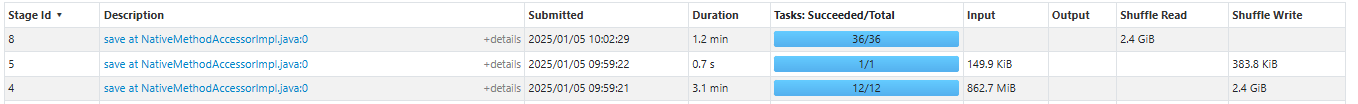

#### Reading the DAG
- Spark applied a not null filter on cust_id
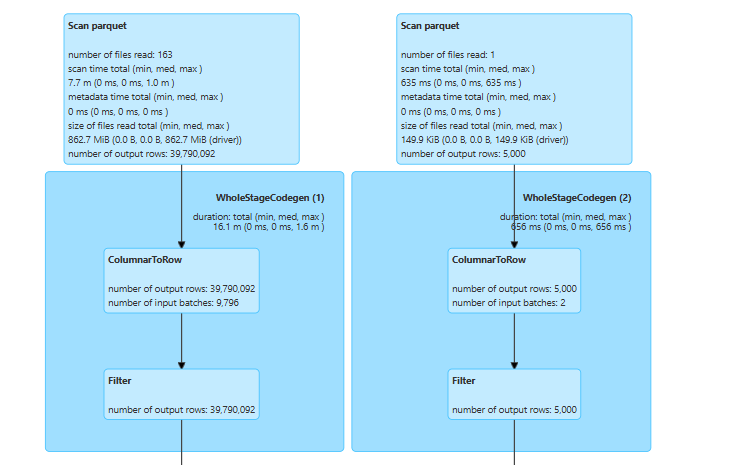


- Then comes the **Shuffle**

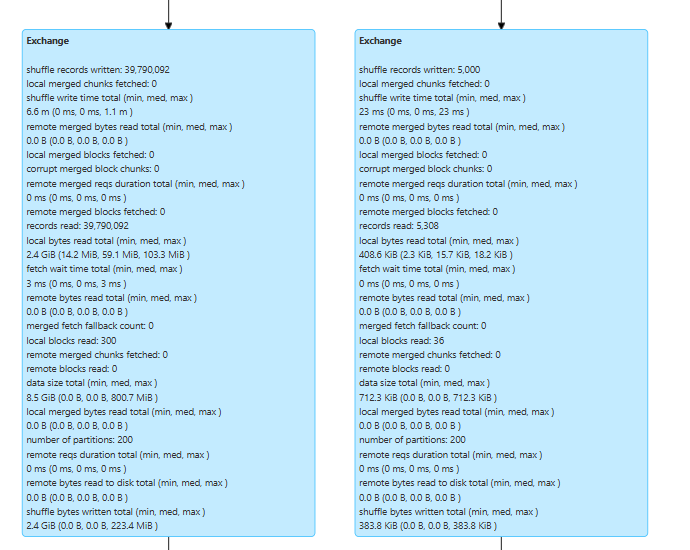

- AQE - **Adaptive Query Execution** : AQE is dynamically optimizing your join operation at runtime
    - Let's break it down for df_transactions:
    - number of coalesced partitions: 24 --> Spark reduced the no. of partitions to 24
    - number of skewed partitions: 1 --> But then it found a partition with skew (a lot more data than the others)
    - number of skewed partition splits: 12 --> So lets split the skewed partition to 12
    - number of partitions: 36 --> Final no. of partitions

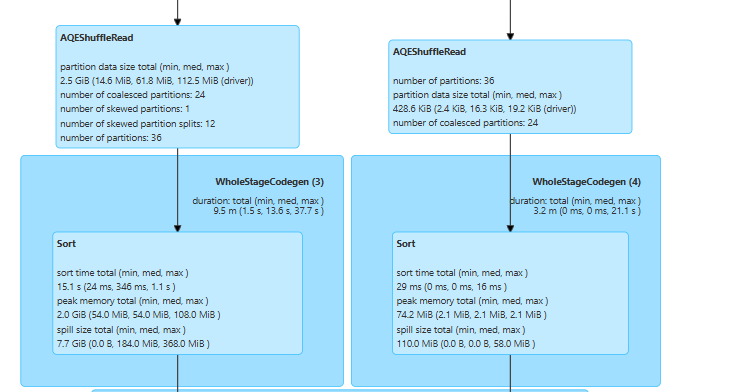

- These are two parallel sort operations preparing data for the join
- This is performing a skew-aware join (skew=true parameter) --> Outputs 39,790,092 rows

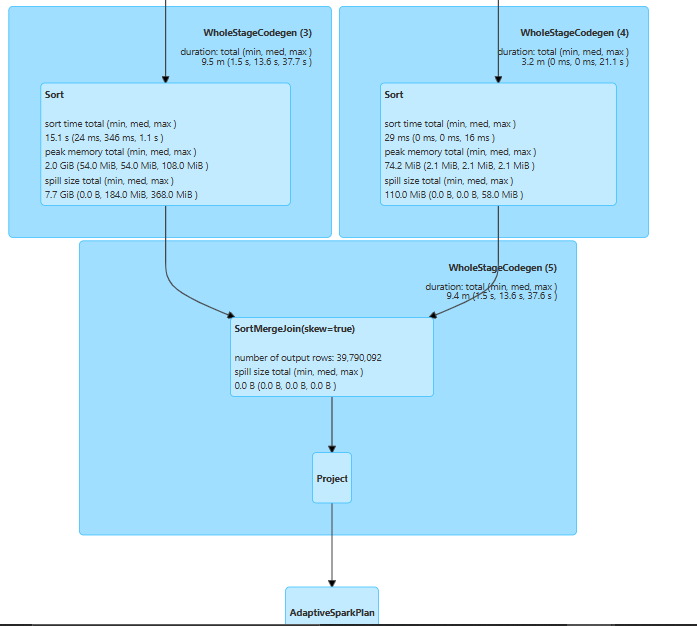

### 2.2. Broadcast Join

In [13]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 10485760)

In [14]:
df_broadcast_joined = (df_transactions.join(F.broadcast(df_customers), how="inner", on="cust_id"))

# Again lets trigger a job using the write NOOP
df_joined.write.format("noop").mode("overwrite").save("df_broadcast_joined.parquet")

- here we have 2 jobs
    - first job to broadcast the smaller dataset
    - second job with the actual join operation

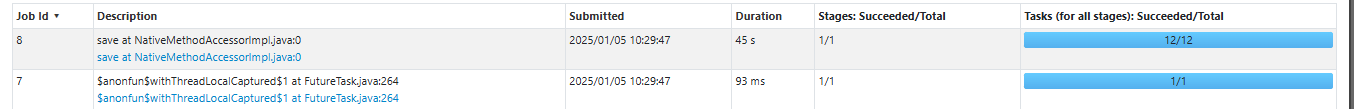

#### DAG for Broadcast

- **BroadcastExchange**
    - The smaller dataset is broadcasted to all the nodes
    - Think of it like photocopying the smaller table and distributing amongst all nodes
- **BroadcastHashJoin**
    - join operation happens in each of the partition since the smaller table has been broadcasted there's no need of shuffle
      
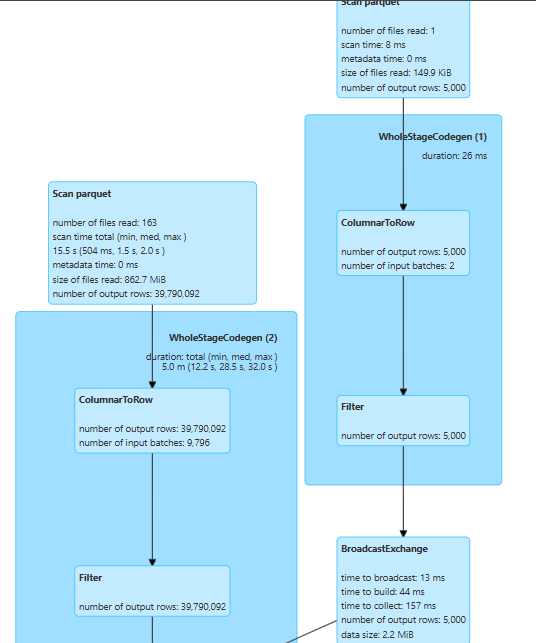
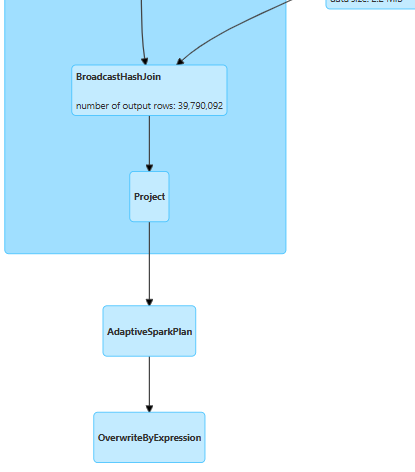

## 3. DAG for Group By

In [15]:
df_city_counts = df_transactions.groupby('city').count()

df_city_counts.show()

+-------------+-------+
|         city|  count|
+-------------+-------+
|    san_diego|3977780|
|      chicago|3979023|
|       denver|3980274|
|       boston|3978268|
|      seattle|3980022|
|  los_angeles|3982028|
|     new_york|3977480|
|san_francisco|3977094|
| philadelphia|3978193|
|     portland|3979930|
+-------------+-------+



- The first stage basically reads in the data and shuffles because of the group by

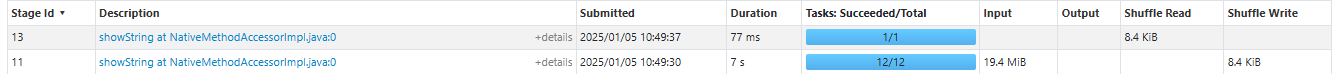

#### DAG for Group By
- **HashAggregate**
    - If you hover it you will see that this step basically means a partial aggregation within the partitions.
    - So it does a count of records split by city

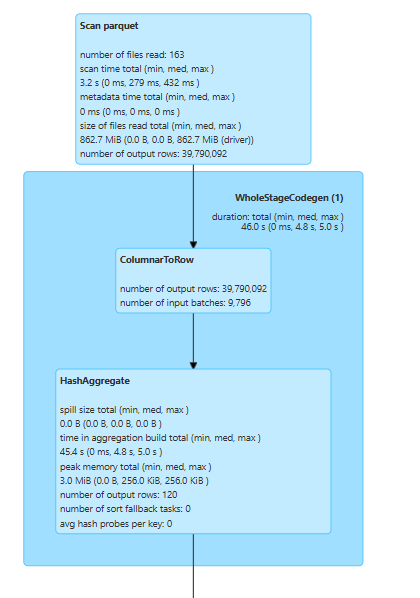

- **Exchange**
    - Shuffle happens on the city
    - All of the same keys goes to the same partitions. If City A in partition #1 then all the records with City A will go to partition #1
    - Default no. of partitions here was 200
   
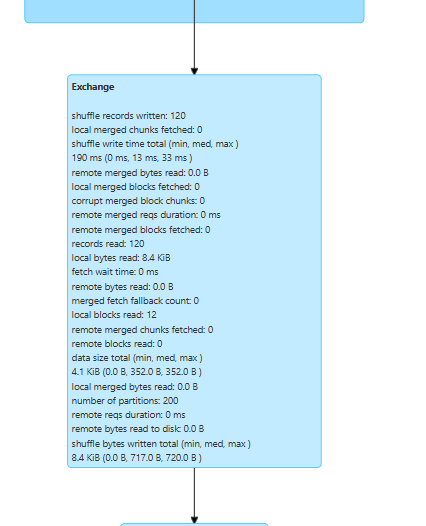

- **AQEShuffleRead**
    - Reduces the no. of partitions from 200 to 1
    - Now does the final count within that reduced partition
  
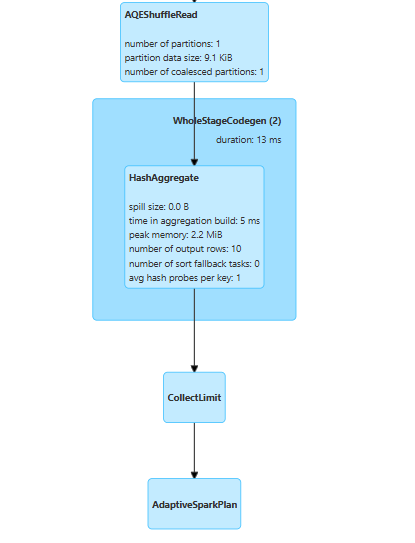


### 3.1. Group By Count Distinct

In [16]:
df_txn_per_city = df_transactions.groupby('cust_id').agg(F.countDistinct('city').alias('city_count'))

df_txn_per_city.show(5, False)

+----------+----------+
|cust_id   |city_count|
+----------+----------+
|CPP8BY8U93|10        |
|CYB8BX9LU1|10        |
|CFRT841CCD|10        |
|CA0TSNMYDK|10        |
|COZ8NONEVZ|10        |
+----------+----------+
only showing top 5 rows



- For this group by there are multiple HashAggregates involved
    - In this first one the function is empty --> this means that Spark is just trying to find the Distinct pairs of cust_id and city within the partitions

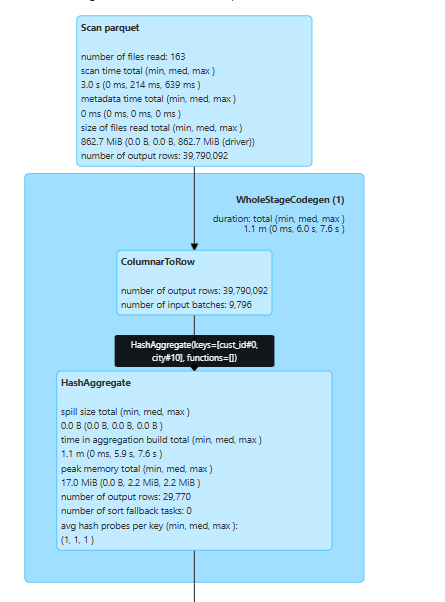

- Exchange happens on the pair of cust_id, city.
    - For instance: (Joyan99, Pune) might go to p#1, so all the other transactions done by Joyan99 in Pune will go to p#1
    - At the end we have 200 partitions

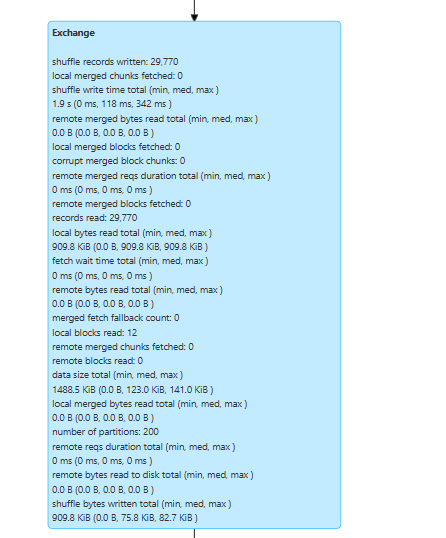

- AQE does it job, reduces the #of partitions from 200 to 1
  
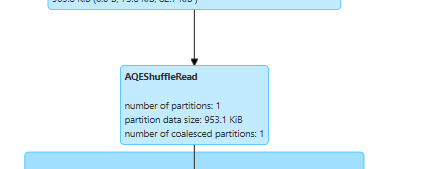

- Here again we see two HashAggregates
    - The first one again is a distinct function since we merged all the partitions
    - The second is a partial count

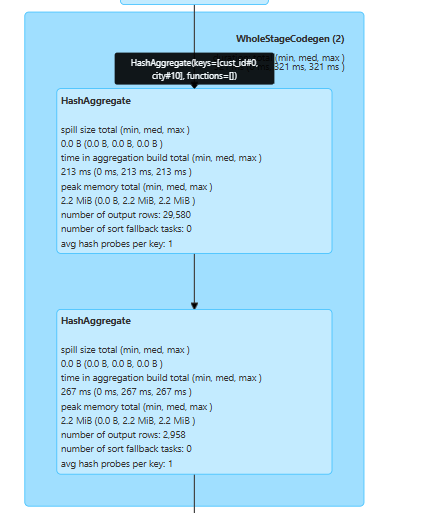

- Again followed by an Exchange on cust_id this time and followed by AQE

 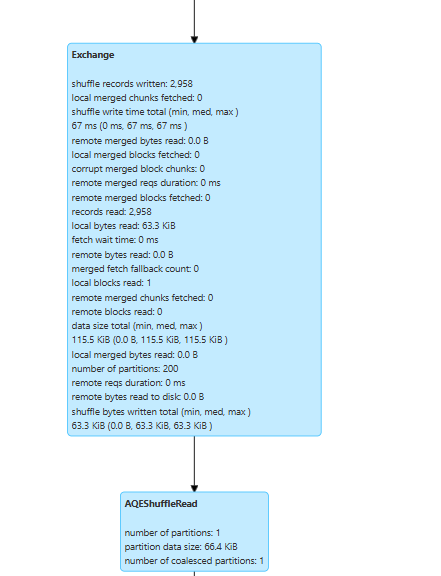